#Initialization

In [176]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [177]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [178]:
seattle_2016 = pd.read_csv("/content/drive/My Drive/OpenClassrooms/PElec_fatmi_amine/P3_seattle_cleaned_fe.csv")

# Train / Test split

## Categorical variables encoding

In [179]:
seattle_2016['ZipCode'] = seattle_2016['ZipCode'].astype('int').astype('str')

In [180]:
seattle_2016['CouncilDistrictCode'] = seattle_2016['CouncilDistrictCode'].astype('str')

In [181]:
cat_features = ['BuildingType', 'PrimaryPropertyType', 'StreetName', 'Neighborhood',
       'LargestPropertyUseType',
       'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ZipCode', 'CouncilDistrictCode']

num_features = ['YearBuilt', 'YearBuilt_binned', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']

energy_cat = ['steam_cat', 'gas_cat', 'elec_cat']

target = ['SiteEnergyUse(kBtu)',
       'TotalGHGEmissions']

num_all = num_features + energy_cat + target

d1 = pd.get_dummies(seattle_2016[cat_features])

In [182]:
seattle_2016 = pd.concat([d1, seattle_2016[num_all]], axis=1)

In [292]:
seattle_2016

,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,StreetName_100TH STREET,StreetName_103RD STREET,StreetName_104TH STREET,StreetName_106TH STREET,StreetName_107TH,StreetName_107TH STREET,StreetName_10TH AVENUE,StreetName_10TH PLACE,StreetName_110TH STREET,StreetName_112TH AT,...,ZipCode_98136,ZipCode_98144,ZipCode_98145,ZipCode_98146,ZipCode_98154,ZipCode_98155,ZipCode_98164,ZipCode_98165,ZipCode_98168,ZipCode_98177,ZipCode_98185,ZipCode_98191,ZipCode_98195,ZipCode_98198,ZipCode_98199,ZipCode_98204,ZipCode_98272,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,YearBuilt,YearBuilt_binned,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,steam_cat,gas_cat,elec_cat,SiteEnergyUse(kBtu),TotalGHGEmissions,PropertyGFABuilding(s)_cat
0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1927,1.0,1.0,12,0.000000,11.390023,11.390023,0.000000,0.000000,60.0,1,1,1,15.793246,5.525373,9.0
1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1996,6.0,1.0,11,9.620129,11.390792,11.337154,9.620129,8.438799,61.0,0,1,1,15.942305,5.693261,9.0
2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1969,4.0,1.0,41,12.189532,13.540275,13.536450,0.000000,0.000000,43.0,1,1,1,18.100297,7.645053,11.0
3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1926,1.0,1.0,10,0.000000,11.023878,11.023878,0.000000,0.000000,56.0,1,1,1,15.731637,5.660979,9.0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1999,6.0,1.0,2,10.524037,11.003615,11.394491,0.000000,0.000000,NaN,0,1,1,16.307609,5.713106,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1982,5.0,1.0,1,0.000000,9.812578,9.812578,0.000000,0.000000,NaN,0,1,1,13.745177,3.060115,8.0
2463,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2004,6.0,1.0,1,0.000000,9.680406,9.680406,0.000000,0.000000,NaN,0,1,1,13.764509,3.501646,8.0
2464,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.

## Random vs Stratified Split

PropertyGFABuilding is an important attribute for both targets so I want to make sure the test set is representative of the various categories of GFABuilding in the whole dataset

Since this attribute is continuous, I need first to create a GFABuilding category attribute.

Text(0.5, 0, 'PropertyGFABuilding(s)_cat')

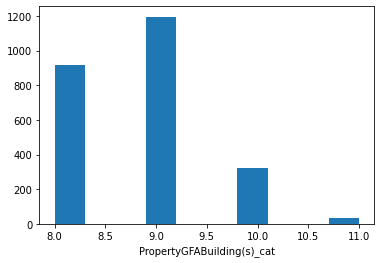

In [184]:
seattle_2016['PropertyGFABuilding(s)_cat'] = np.ceil(seattle_2016['PropertyGFABuilding(s)']/1.3)
plt.hist(seattle_2016['PropertyGFABuilding(s)_cat'])
plt.xlabel('PropertyGFABuilding(s)_cat')

In [185]:
seattle_2016['PropertyGFABuilding(s)_cat'].value_counts()

9.0     1196
8.0      916
10.0     320
11.0      35
Name: PropertyGFABuilding(s)_cat, dtype: int64

In [186]:
# random split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(seattle_2016, test_size=0.2, random_state=37)

In [187]:
# stratified split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37)
for train_index, test_index in split.split(seattle_2016, seattle_2016['PropertyGFABuilding(s)_cat']):
  strat_train_set = seattle_2016.loc[train_index]
  strat_test_set = seattle_2016.loc[test_index]

In [188]:
# overall GFAbuilding category proportions
overall = seattle_2016['PropertyGFABuilding(s)_cat'].value_counts() / len(seattle_2016)
overall = pd.Series(overall).rename('Overall')
overall

9.0     0.484799
8.0     0.371301
10.0    0.129712
11.0    0.014187
Name: Overall, dtype: float64

In [189]:
# PropertyGFABuilding category proportions in the test set generated using random sampling
random = test_set['PropertyGFABuilding(s)_cat'].value_counts() / len(test_set)
random = pd.Series(random).rename('Random')

rand_error = (random-overall)/overall * 100
rand_error = pd.Series(rand_error).rename('Rand. %error')
rand_error

9.0     -1.875178
8.0      7.402145
10.0    -9.485071
11.0   -42.926547
Name: Rand. %error, dtype: float64

In [190]:
# PropertyGFABuilding category proportions in the test set generated with stratified sampling
stratified = strat_test_set['PropertyGFABuilding(s)_cat'].value_counts() / len(test_set)
stratified = pd.Series(stratified).rename('Stratified')

strat_error = (stratified - overall)/overall * 100
strat_error = pd.Series(strat_error).rename('Strat. %error')
strat_error

9.0     0.212584
8.0    -0.230495
10.0   -0.121457
11.0   -0.121457
Name: Strat. %error, dtype: float64

In [191]:
round(pd.DataFrame([overall,random, stratified, rand_error, strat_error]).transpose(), 3)

,Overall,Random,Stratified,Rand. %error,Strat. %error
9.0,0.485,0.476,0.486,-1.875,0.213
8.0,0.371,0.399,0.370,7.402,-0.230
10.0,0.130,0.117,0.130,-9.485,-0.121
11.0,0.014,0.008,0.014,-42.927,-0.121


In [192]:
for set in (strat_train_set, strat_test_set):
  set.drop(['PropertyGFABuilding(s)_cat'], axis=1, inplace=True)

In [193]:
cat_features = ['BuildingType', 'PrimaryPropertyType', 'StreetName', 'Neighborhood',
       'LargestPropertyUseType',
       'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ZipCode', 'CouncilDistrictCode']

# create lists to include names of dummy variables 
building_type_dummy = strat_train_set.filter(regex=cat_features[0]).columns
primary_type_dummy = strat_train_set.filter(regex=cat_features[1]).columns
street_name_dummy = strat_train_set.filter(regex=cat_features[2]).columns
neighborhood_dummy = strat_train_set.filter(regex=cat_features[3]).columns
largest_type_dummy = strat_train_set.drop('LargestPropertyUseTypeGFA', axis=1).filter(regex='^'+cat_features[4]).columns
second_largest_type_dummy = strat_train_set.drop('SecondLargestPropertyUseTypeGFA', axis=1).filter(regex=cat_features[5]).columns
third_largest_type_dummy = strat_train_set.drop('ThirdLargestPropertyUseTypeGFA', axis=1).filter(regex=cat_features[6]).columns
zip_code_dummy = strat_train_set.filter(regex=cat_features[7]).columns
council_code_dummy = strat_train_set.filter(regex=cat_features[8]).columns

In [194]:
# define class DataFrameSelector for the pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.attribute_names].values

# Baseline models evaluation

## With ESS

In [195]:
num_features = ['NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']

num_year = ['YearBuilt', 'YearBuilt_binned']

energy_cat = ['steam_cat', 'gas_cat', 'elec_cat']

target = ['SiteEnergyUse(kBtu)',
       'TotalGHGEmissions']

cat_all = list(building_type_dummy) + list(primary_type_dummy) + list(street_name_dummy) + list(neighborhood_dummy)\
+ list(largest_type_dummy) + list(second_largest_type_dummy) + list(third_largest_type_dummy) \
+ list(zip_code_dummy) + list(council_code_dummy)

In [196]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_all)),                      
])

num_year_pipeline = Pipeline([
                         ('selector', DataFrameSelector(['YearBuilt_binned'])),                      
])

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_features)),
                         ('knn_imputer', KNNImputer(n_neighbors=5)),
                         ('std_scaler', StandardScaler())
])

energy_cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(energy_cat)),                      
])

full_pipeline = FeatureUnion(transformer_list=[
                                           ('cat_pipeline', cat_pipeline),
                                           ('num_year_pipeline', num_year_pipeline),
                                           ('num_pipeline', num_pipeline),
                                           ('energy_cat_pipeline', energy_cat_pipeline)                                        
])

In [197]:
target_pipeline = Pipeline([
                         ('selector', DataFrameSelector(target)),
                         ('std_scaler', StandardScaler())
])

In [198]:
# Transform feature and target using pipelines defined above
X_train_prep = full_pipeline.fit_transform(strat_train_set.copy())
y_train_prep_seu = target_pipeline.fit_transform(strat_train_set.copy())[:,0]
y_train_prep_ghge = target_pipeline.fit_transform(strat_train_set.copy())[:,1]

### Site Energy Use

In [199]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

dr = DummyRegressor(strategy='mean')
rdg = Ridge(random_state=37)
ls = Lasso(random_state=37)
knn = KNeighborsRegressor()
svr = SVR()
rf = RandomForestRegressor(random_state=37)
xgb = XGBRegressor(objective ='reg:squarederror',random_state=37)

In [200]:
# compute score means for each regressor and store in a dictionary. R2, MAE and RMSE
regressor_list = [rdg, ls, knn, svr, rf, xgb]
score_dict={}
for measure in ('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'):

  for reg in regressor_list:
    score = cross_val_score(reg, X_train_prep, y_train_prep_seu, cv=3, scoring=measure)

    if measure in score_dict:
      score_dict[measure].append(score.mean())
    else:
      score_dict[measure] = [score.mean()]

In [202]:
# display results in a df
regressor_name = ['Ridge', 'Lasso', 'KNN', 'SVR', 'RandomForest', 'XGBoost']
score1 = pd.DataFrame(score_dict, index=regressor_name)
score1['MAE'] = -score1['neg_mean_absolute_error']
score1['MSE'] = -score1['neg_mean_squared_error']
score1['RMSE'] = np.sqrt(-score1['neg_mean_squared_error'])
score1.drop(['neg_mean_squared_error', 'neg_mean_absolute_error'], axis=1, inplace=True)
score1.round(decimals=3)

,r2,MAE,MSE,RMSE
Ridge,0.804,0.315,0.195,0.442
Lasso,-0.004,0.794,1.002,1.001
KNN,0.644,0.427,0.355,0.596
SVR,0.809,0.293,0.190,0.436
RandomForest,0.791,0.305,0.209,0.457
XGBoost,0.814,0.294,0.185,0.431


### Total GHGE

In [206]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

dummy_reg = DummyRegressor(strategy='mean')
rdg = Ridge(random_state=37)
ls = Lasso(random_state=37)
knn = KNeighborsRegressor()
svr = SVR()
rf = RandomForestRegressor(random_state=37)
xgb = XGBRegressor(objective ='reg:squarederror',random_state=37)

In [207]:
regressor_list = [rdg, ls, knn, svr, rf, xgb]
score_dict={}
for measure in ('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'):

  for reg in regressor_list:
    score = cross_val_score(reg, X_train_prep, y_train_prep_ghge, cv=3, scoring=measure)

    if measure in score_dict:
      score_dict[measure].append(score.mean())
    else:
      score_dict[measure] = [score.mean()]

In [208]:
regressor_name = ['Ridge', 'Lasso', 'KNN', 'SVR', 'RandomForest', 'XGBoost']
score2 = pd.DataFrame(score_dict, index=regressor_name)
score2['MAE'] = -score2['neg_mean_absolute_error']
score2['MSE'] = -score2['neg_mean_squared_error']
score2['RMSE'] = np.sqrt(-score2['neg_mean_squared_error'])
score2.drop(['neg_mean_squared_error', 'neg_mean_absolute_error'], axis=1, inplace=True)
score2.round(decimals=3)

,r2,MAE,MSE,RMSE
Ridge,0.756,0.372,0.243,0.493
Lasso,-0.004,0.830,1.002,1.001
KNN,0.533,0.517,0.467,0.683
SVR,0.775,0.345,0.225,0.474
RandomForest,0.774,0.336,0.225,0.475
XGBoost,0.793,0.329,0.206,0.454


## W/O ESS

In [209]:
num_features = ['NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA']

num_year = ['YearBuilt', 'YearBuilt_binned']

energy_cat = ['steam_cat', 'gas_cat', 'elec_cat']

target = ['SiteEnergyUse(kBtu)',
       'TotalGHGEmissions']

cat_all = list(building_type_dummy) + list(primary_type_dummy) + list(street_name_dummy) + list(neighborhood_dummy)\
+ list(largest_type_dummy) + list(second_largest_type_dummy) + list(third_largest_type_dummy) \
+ list(zip_code_dummy) + list(council_code_dummy)

In [210]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_all)),                      
])

num_year_pipeline = Pipeline([
                         ('selector', DataFrameSelector(['YearBuilt_binned'])),                      
])

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_features)),
                         ('knn_imputer', KNNImputer(n_neighbors=5)),
                         ('std_scaler', StandardScaler())
])

energy_cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(energy_cat)),                      
])

full_pipeline = FeatureUnion(transformer_list=[
                                           ('cat_pipeline', cat_pipeline),
                                           ('num_year_pipeline', num_year_pipeline),
                                           ('num_pipeline', num_pipeline),
                                           ('energy_cat_pipeline', energy_cat_pipeline)                                        
])

In [211]:
target_pipeline = Pipeline([
                         ('selector', DataFrameSelector(target)),
                         ('std_scaler', StandardScaler())
])

In [212]:
X_train_prep = full_pipeline.fit_transform(strat_train_set.copy())
y_train_prep_seu = target_pipeline.fit_transform(strat_train_set.copy())[:,0]
y_train_prep_ghge = target_pipeline.fit_transform(strat_train_set.copy())[:,1]

### Site Energy Use

In [213]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

dummy_reg = DummyRegressor(strategy='mean')
rdg = Ridge(random_state=37)
ls = Lasso(random_state=37)
knn = KNeighborsRegressor()
svr = SVR()
rf = RandomForestRegressor(random_state=37)
xgb = XGBRegressor(objective ='reg:squarederror',random_state=37)

In [214]:
regressor_list = [rdg, ls, knn, svr, rf, xgb]
score_dict={}
for measure in ('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'):

  for reg in regressor_list:
    score = cross_val_score(reg, X_train_prep, y_train_prep_seu, cv=3, scoring=measure)

    if measure in score_dict:
      score_dict[measure].append(score.mean())
    else:
      score_dict[measure] = [score.mean()]

In [216]:
regressor_name = ['Ridge', 'Lasso', 'KNN', 'SVR', 'RandomForest', 'XGBoost']
score3 = pd.DataFrame(score_dict, index=regressor_name)
score3['MAE'] = -score3['neg_mean_absolute_error']
score3['MSE'] = -score3['neg_mean_squared_error']
score3['RMSE'] = np.sqrt(-score3['neg_mean_squared_error'])
score3.drop(['neg_mean_squared_error', 'neg_mean_absolute_error'], axis=1, inplace=True)
score3.round(decimals=3)

,r2,MAE,MSE,RMSE
Ridge,0.760,0.357,0.239,0.489
Lasso,-0.004,0.794,1.002,1.001
KNN,0.615,0.449,0.384,0.619
SVR,0.766,0.334,0.233,0.483
RandomForest,0.757,0.343,0.243,0.493
XGBoost,0.772,0.340,0.227,0.477


### Total GHGE

In [218]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

dummy_reg = DummyRegressor(strategy='mean')
rdg = Ridge(random_state=37)
ls = Lasso(random_state=37)
knn = KNeighborsRegressor()
svr = SVR()
rf = RandomForestRegressor(random_state=37)
xgb = XGBRegressor(objective ='reg:squarederror',random_state=37)

In [219]:
regressor_list = [rdg, ls, knn, svr, rf, xgb]
score_dict={}
for measure in ('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'):

  for reg in regressor_list:
    score = cross_val_score(reg, X_train_prep, y_train_prep_ghge, cv=3, scoring=measure)

    if measure in score_dict:
      score_dict[measure].append(score.mean())
    else:
      score_dict[measure] = [score.mean()]

In [220]:
regressor_name = ['Ridge', 'Lasso', 'KNN', 'SVR', 'RandomForest', 'XGBoost']
score4= pd.DataFrame(score_dict, index=regressor_name)
score4['MAE'] = -score4['neg_mean_absolute_error']
score4['MSE'] = -score4['neg_mean_squared_error']
score4['RMSE'] = np.sqrt(-score4['neg_mean_squared_error'])
score4.drop(['neg_mean_squared_error', 'neg_mean_absolute_error'], axis=1, inplace=True)
score4.round(decimals=3)

,r2,MAE,MSE,RMSE
Ridge,0.737,0.389,0.262,0.512
Lasso,-0.004,0.830,1.002,1.001
KNN,0.522,0.523,0.477,0.691
SVR,0.758,0.361,0.242,0.491
RandomForest,0.762,0.350,0.238,0.488
XGBoost,0.774,0.350,0.226,0.475


# Hyperparameter tuning (on SEU with ESS - r2 metric)

In [221]:
num_features = ['NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']

num_year = ['YearBuilt', 'YearBuilt_binned']

energy_cat = ['steam_cat', 'gas_cat', 'elec_cat']

target = ['SiteEnergyUse(kBtu)',
       'TotalGHGEmissions']

cat_all = list(building_type_dummy) + list(primary_type_dummy) + list(street_name_dummy) + list(neighborhood_dummy)\
+ list(largest_type_dummy) + list(second_largest_type_dummy) + list(third_largest_type_dummy) \
+ list(zip_code_dummy) + list(council_code_dummy)

In [222]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_all)),                      
])

num_year_pipeline = Pipeline([
                         ('selector', DataFrameSelector(['YearBuilt_binned'])),                      
])

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_features)),
                         ('knn_imputer', KNNImputer(n_neighbors=5)),
                         ('std_scaler', StandardScaler())
])

energy_cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(energy_cat)),                      
])

full_pipeline = FeatureUnion(transformer_list=[
                                           ('cat_pipeline', cat_pipeline),
                                           ('num_year_pipeline', num_year_pipeline),
                                           ('num_pipeline', num_pipeline),
                                           ('energy_cat_pipeline', energy_cat_pipeline)                                        
])

In [223]:
target_pipeline = Pipeline([
                         ('selector', DataFrameSelector(target)),
                         ('std_scaler', StandardScaler())
])

In [224]:
X_train_prep = full_pipeline.fit_transform(strat_train_set.copy())
y_train_prep_seu = target_pipeline.fit_transform(strat_train_set.copy())[:,0]

## Lasso

In [226]:
lasso_param = {'alpha': [0.0005, 0.0009, 0.001, 0.0011, 0.0015, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}

ls_gr_sr = GridSearchCV(ls, param_grid=lasso_param, scoring='r2', cv=3, n_jobs=-1)
ls_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, ls_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'alpha': 0.001}, 0.8221765214413553)

In [227]:
best_lasso = {'alpha': 0.001}

## Ridge

In [228]:
ridge_param = {'alpha': [0.1, 1.0, 5.0, 6, 7, 8, 9, 10., 12, 20., 50., 100., 200, 300, 500]}

rd_gr_sr = GridSearchCV(rdg, param_grid=ridge_param, scoring='r2', cv=3, n_jobs=-1)
rd_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, rd_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'alpha': 7}, 0.8201710318520449)

In [ ]:
best_ridge = {'alpha': 7}

## KNN

In [229]:
knn_param = {'n_neighbors': [5,10, 15],
             'weights': ['distance'],
             'algorithm': ['ball_tree'],
             }

knn_gr_sr = GridSearchCV(knn, param_grid=knn_param, scoring='r2', cv=3, n_jobs=-1)
knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'},
 0.6541300337542799)

In [230]:
knn_param = {'n_neighbors': [9, 10, 11],
             'weights': ['distance'],
             'algorithm': ['ball_tree'],
             }

knn_gr_sr = GridSearchCV(knn, param_grid=knn_param, scoring='r2', cv=3, n_jobs=-1)
knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'},
 0.6565553417092892)

In [231]:
knn_param = {'n_neighbors': [8, 9],
             'weights': ['distance'],
             'algorithm': ['ball_tree'],
             }

knn_gr_sr = GridSearchCV(knn, param_grid=knn_param, scoring='r2', cv=3, n_jobs=-1)
knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'},
 0.6567000124767316)

In [232]:
knn_param = {'n_neighbors': [7, 8],
             'weights': ['distance'],
             'algorithm': ['ball_tree'],
             }

knn_gr_sr = GridSearchCV(knn, param_grid=knn_param, scoring='r2', cv=3, n_jobs=-1)
knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, knn_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'},
 0.6567000124767316)

In [ ]:
best_knn = {'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}

## SVR

In [233]:
svr_param = {
             'kernel': ['rbf'],
             'gamma': ['scale'],
             'C': [1.0, 2.0],
             'epsilon': [0.1, 0.2]
             }

svr_gr_sr = GridSearchCV(svr, param_grid=svr_param, scoring='r2', cv=3, n_jobs=-1)
svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'C': 2.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'},
 0.8201829482810609)

In [234]:
svr_param = {
             'kernel': ['rbf'],
             'gamma': ['scale'],
             'C': [2.0, 5.0],
             'epsilon': [0.2, 0.5]
             }

svr_gr_sr = GridSearchCV(svr, param_grid=svr_param, scoring='r2', cv=3, n_jobs=-1)
svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'C': 2.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'},
 0.8201829482810609)

In [235]:
svr_param = {
             'kernel': ['rbf'],
             'gamma': ['scale'],
             'C': [2.0, 3.0],
             'epsilon': [0.2, 0.3]
             }

svr_gr_sr = GridSearchCV(svr, param_grid=svr_param, scoring='r2', cv=3, n_jobs=-1)
svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'},
 0.8209824560226155)

In [236]:
svr_param = {
             'kernel': ['rbf'],
             'gamma': ['scale'],
             'C': [3.0, 4.0],
             'epsilon': [0.2, 0.25]
             }

svr_gr_sr = GridSearchCV(svr, param_grid=svr_param, scoring='r2', cv=3, n_jobs=-1)
svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'},
 0.8209824560226155)

In [237]:
svr_param = {
             'kernel': ['rbf'],
             'gamma': ['scale'],
             'C': [2.5, 3.0, 3.5],
             'epsilon': [0.2, 0.25]
             }

svr_gr_sr = GridSearchCV(svr, param_grid=svr_param, scoring='r2', cv=3, n_jobs=-1)
svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'C': 2.5, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'},
 0.8210226569106055)

In [238]:
svr_param = {
             'kernel': ['rbf'],
             'gamma': ['scale'],
             'C': [2.3, 2.5, 2.7],
             'epsilon': [0.2]
             }

svr_gr_sr = GridSearchCV(svr, param_grid=svr_param, scoring='r2', cv=3, n_jobs=-1)
svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'C': 2.7, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'},
 0.8210779263671576)

In [239]:
svr_param = {
             'kernel': ['rbf'],
             'gamma': ['scale'],
             'C': [2.6, 2.7, 2.8],
             'epsilon': [0.2]
             }

svr_gr_sr = GridSearchCV(svr, param_grid=svr_param, scoring='r2', cv=3, n_jobs=-1)
svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, svr_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'C': 2.6, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'},
 0.8210885015087834)

In [ ]:
best_svr = {'C': 2.6, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}

## RandomForest

In [ ]:
rf_param = {
  'max_features': ['auto'],
  'min_samples_leaf': [1, 5, 10],
  'min_samples_split': [2, 4, 10, 16],
  'n_estimators': [50, 100, 400, 700, 1000]}
  
rf_gr_sr = GridSearchCV(rf, param_grid=rf_param, scoring='r2', cv=3, n_jobs=-1)
rf_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, rf_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

In [241]:
rf_param = {
  'max_features': ['auto'],
  'min_samples_leaf': [1],
  'min_samples_split': [2],
  'n_estimators': [1000]}
  
rf_gr_sr = GridSearchCV(rf, param_grid=rf_param, scoring='r2', cv=3, n_jobs=-1)
rf_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, rf_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 1000},
 0.7918159910376522)

In [ ]:
best_rf = {'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 1000}

## XGBoost

In [242]:
param_xgb = {
        'learning_rate': [0.11],
        'max_depth': [3],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.11,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8271238785313647)

In [243]:
param_xgb = {
        'learning_rate': [0.11],
        'max_depth': [3],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300, 400, 500]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.11,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8271238785313647)

In [244]:
param_xgb = {
        'learning_rate': [0.11],
        'max_depth': [3],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [200, 300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.11,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8271238785313647)

In [245]:
param_xgb = {
        'learning_rate': [0.05, 0.11, 0.2],
        'max_depth': [3],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8272869217609863)

In [246]:
param_xgb = {
        'learning_rate': [0.03, 0.05, 0.07],
        'max_depth': [3],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8272869217609863)

In [247]:
param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [2,3],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8272869217609863)

In [248]:
param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [3, 5],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8285607805566405)

In [249]:
param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [5, 10],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8285607805566405)

In [250]:
param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [4, 5, 7],
        'min_child_weight': [1],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 4,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8286458833303629)

In [253]:
param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [4],
        'min_child_weight': [1,2],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 4,
  'min_child_weight': 2,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8304464856984902)

In [254]:
param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [4],
        'min_child_weight': [2, 4],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 4,
  'min_child_weight': 2,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8304464856984902)

In [255]:
param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [4],
        'min_child_weight': [2, 3],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 4,
  'min_child_weight': 2,
  'n_estimators': 300,
  'subsample': 0.5},
 0.8304464856984902)

In [256]:
best_xgb = {'colsample_bytree': 0.5,
  'learning_rate': 0.05,
  'max_depth': 4,
  'min_child_weight': 2,
  'n_estimators': 300,
  'subsample': 0.5}

# Best model: XGBoost

In [257]:
ls_gr_sr.best_score_, rd_gr_sr.best_score_, knn_gr_sr.best_score_, svr_gr_sr.best_score_, rf_gr_sr.best_score_, xgb_gr_sr.best_score_

(0.8221765214413553,
 0.8201710318520449,
 0.6567000124767316,
 0.8210885015087834,
 0.7918159910376522,
 0.8304464856984902)

In [258]:
pd.Series([0.822, 0.820, 0.657, 0.821, 0.792, 0.830], index=['Lasso','Ridge', 'KNN', 'SVR', 'RandomForest', 'XGBoost'])

Lasso           0.822
Ridge           0.820
KNN             0.657
SVR             0.821
RandomForest    0.792
XGBoost         0.830
dtype: float64

XGBoost is the best performing model after tuning.

## Runtime

Let's evaluate the running time of XGBoost on a cross-validationwith 3 folds.



In [259]:
import time

In [260]:
start = time.time()

param_xgb = {
        'learning_rate': [0.05],
        'max_depth': [4],
        'min_child_weight': [2],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [300]
    }

xgb_gr_sr = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_params_, xgb_gr_sr.fit(X_train_prep, y_train_prep_seu).best_score_

end = time.time()
xgb_runtime = end -start

print(xgb_runtime, xgb_gr_sr.best_score_)

42.15364694595337 0.8304464856984902


I will now check features importance for XGBoost and try to reduce the number of features. Then, I will show how it impacts both speed and score.

## Feature importance

In [261]:
# create a list of all features
features_name = cat_all + ['YearBuilt_binned'] + num_features + energy_cat

In [266]:
num_features

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore']

In [264]:
xgb_gr_sr.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=2, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=37, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, verbosity=1)

In [276]:
# check the 20 most important features
xgb_feat_importance = pd.Series(xgb_gr_sr.best_estimator_.feature_importances_, index=features_name)
xgb_feat_importance.sort_values(ascending=False)[:50]

PrimaryPropertyType_Low-Rise Multifamily                       0.075623
PropertyGFABuilding(s)                                         0.051023
LargestPropertyUseTypeGFA                                      0.046124
PropertyGFAParking                                             0.033506
PrimaryPropertyType_High-Rise Multifamily                      0.030162
LargestPropertyUseType_Supermarket/Grocery Store               0.023231
gas_cat                                                        0.021279
LargestPropertyUseType_Multifamily Housing                     0.017168
PrimaryPropertyType_Supermarket / Grocery Store                0.017120
PrimaryPropertyType_Warehouse                                  0.016358
BuildingType_Multifamily LR (1-4)                              0.015407
PrimaryPropertyType_Self-Storage Facility                      0.013932
LargestPropertyUseType_Non-Refrigerated Warehouse              0.013747
PrimaryPropertyType_Other                                      0

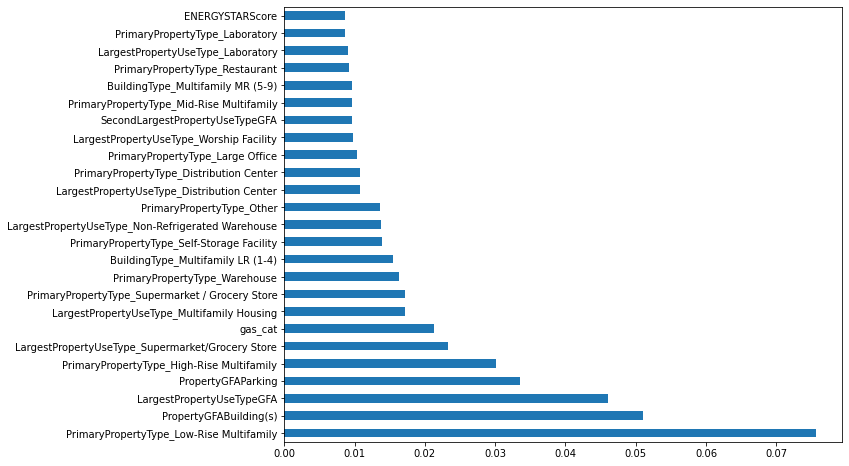

In [270]:
plt.figure(figsize=(10,8))
xgb_feat_importance.sort_values(ascending=False)[:25].plot(kind='barh')

I will filter the features by only keeping those with a coefficient higher that 0.005.

In [277]:
# select features with coef > 0.005 (n_features = 48)
if_col = xgb_feat_importance.sort_values(ascending=False)[:48].index

In [311]:
# important features w/o ESS
if_col_wo_ess = list(if_col)
if_col_wo_ess.remove('ENERGYSTARScore') 
len(if_col), len(if_col_wo_ess)

(48, 47)

In [278]:
# filter X_train to keep only the most important 48 features
X_train_prep_if = pd.DataFrame(X_train_prep, columns=features_name)
X_train_prep_if = X_train_prep_if[if_col]

Let's check now the performance of XGBoost model after the feature selection

In [280]:
import time

start = time.time()
xgb_gr_sr_if = GridSearchCV(xgb, param_grid=param_xgb, scoring='r2', cv=3, n_jobs=-1)
xgb_gr_sr_if.fit(X_train_prep_if, y_train_prep_seu).best_params_, xgb_gr_sr_if.fit(X_train_prep_if, y_train_prep_seu).best_score_

end = time.time()
xgb_if_runtime = end - start

print(xgb_if_runtime, xgb_gr_sr_if.best_score_)


5.919443130493164 0.8283710855784756


It is way faster than before feature selection. The score went slightly down from 0.830 to 0.828.

**I will be using this tuned and reduced XGBoost model as a final model.**

# Final validation with ESS

In [295]:
# XGBoost with optimal parameters
xgb_final = xgb_gr_sr_if.best_estimator_

In [296]:
num_features = ['NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']

num_year = ['YearBuilt', 'YearBuilt_binned']

energy_cat = ['steam_cat', 'gas_cat', 'elec_cat']

target = ['SiteEnergyUse(kBtu)',
       'TotalGHGEmissions']

cat_all = list(building_type_dummy) + list(primary_type_dummy) + list(street_name_dummy) + list(neighborhood_dummy)\
+ list(largest_type_dummy) + list(second_largest_type_dummy) + list(third_largest_type_dummy) \
+ list(zip_code_dummy) + list(council_code_dummy)

In [297]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_all)),                      
])

num_year_pipeline = Pipeline([
                         ('selector', DataFrameSelector(['YearBuilt_binned'])),                      
])

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_features)),
                         ('knn_imputer', KNNImputer(n_neighbors=5)),
                         ('std_scaler', StandardScaler())
])

energy_cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(energy_cat)),                      
])

full_pipeline = FeatureUnion(transformer_list=[
                                           ('cat_pipeline', cat_pipeline),
                                           ('num_year_pipeline', num_year_pipeline),
                                           ('num_pipeline', num_pipeline),
                                           ('energy_cat_pipeline', energy_cat_pipeline)                                        
])

In [298]:
target_pipeline = Pipeline([
                         ('selector', DataFrameSelector(target)),
                         ('std_scaler', StandardScaler())
])

In [299]:
# prepare training set 
X_train_prep = full_pipeline.fit_transform(strat_train_set.copy())
y_train_prep_seu = target_pipeline.fit_transform(strat_train_set.copy())[:,0]
y_train_prep_ghge = target_pipeline.fit_transform(strat_train_set.copy())[:,1]

In [300]:
# prepare the test set (fit and not fit_transform to apply the same transormation as training set)
X_test_prep = full_pipeline.transform(strat_test_set.copy())
y_test_prep_seu = target_pipeline.transform(strat_test_set.copy())[:,0]
y_test_prep_ghge = target_pipeline.transform(strat_test_set.copy())[:,1]

In [302]:
# filter X_train to keep only the most important 48 features
X_train_prep_if = pd.DataFrame(X_train_prep, columns=features_name)
X_train_prep_if = X_train_prep_if[if_col]

# filter X_test to keep only the most important 48 features
X_test_prep_if = pd.DataFrame(X_test_prep, columns=features_name)
X_test_prep_if = X_test_prep_if[if_col]

## prediction SEU

In [303]:
y_pred = xgb_final.predict(X_test_prep_if)

seu_score = r2_score(y_pred, y_test_prep_seu)
seu_score

0.7813713802975009

## prediction GHGE

In [306]:
xgb_final.fit(X_train_prep_if, y_train_prep_ghge)

y_pred = xgb_final.predict(X_test_prep_if)

ghge_score = r2_score(y_pred, y_test_prep_ghge)
ghge_score

0.7610110644622722

# Final validation w/o ESS

In [333]:
# XGBoost with optimal parameters
xgb_final = xgb_gr_sr_if.best_estimator_

In [334]:
num_features = ['NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA']

num_year = ['YearBuilt', 'YearBuilt_binned']

energy_cat = ['steam_cat', 'gas_cat', 'elec_cat']

target = ['SiteEnergyUse(kBtu)',
       'TotalGHGEmissions']

cat_all = list(building_type_dummy) + list(primary_type_dummy) + list(street_name_dummy) + list(neighborhood_dummy)\
+ list(largest_type_dummy) + list(second_largest_type_dummy) + list(third_largest_type_dummy) \
+ list(zip_code_dummy) + list(council_code_dummy)

In [335]:
features_name = cat_all + ['YearBuilt_binned'] + num_features + energy_cat

In [336]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(cat_all)),                      
])

num_year_pipeline = Pipeline([
                         ('selector', DataFrameSelector(['YearBuilt_binned'])),                      
])

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_features)),
                         ('knn_imputer', KNNImputer(n_neighbors=5)),
                         ('std_scaler', StandardScaler())
])

energy_cat_pipeline = Pipeline([
                         ('selector', DataFrameSelector(energy_cat)),                      
])

full_pipeline = FeatureUnion(transformer_list=[
                                           ('cat_pipeline', cat_pipeline),
                                           ('num_year_pipeline', num_year_pipeline),
                                           ('num_pipeline', num_pipeline),
                                           ('energy_cat_pipeline', energy_cat_pipeline)                                        
])

In [337]:
target_pipeline = Pipeline([
                         ('selector', DataFrameSelector(target)),
                         ('std_scaler', StandardScaler())
])

In [338]:
# prepare training set 
X_train_prep = full_pipeline.fit_transform(strat_train_set.copy())
y_train_prep_seu = target_pipeline.fit_transform(strat_train_set.copy())[:,0]
y_train_prep_ghge = target_pipeline.fit_transform(strat_train_set.copy())[:,1]

In [339]:
# prepare the test set (fit and not fit_transform to apply the same transormation as training set)
X_test_prep = full_pipeline.transform(strat_test_set.copy())
y_test_prep_seu = target_pipeline.transform(strat_test_set.copy())[:,0]
y_test_prep_ghge = target_pipeline.transform(strat_test_set.copy())[:,1]

In [341]:
# filter X_train to keep only the most important 48 features
X_train_prep_if = pd.DataFrame(X_train_prep, columns=features_name)
X_train_prep_if = X_train_prep_if[if_col_wo_ess]

# filter X_test to keep only the most important 48 features
X_test_prep_if = pd.DataFrame(X_test_prep, columns=features_name)
X_test_prep_if = X_test_prep_if[if_col_wo_ess]

## prediction SEU

In [345]:
xgb_final.fit(X_train_prep_if, y_train_prep_seu)
y_pred = xgb_final.predict(X_test_prep_if)

seu_score = r2_score(y_pred, y_test_prep_seu)
seu_score

0.7399263951651937

## prediction GHGE

In [346]:
xgb_final.fit(X_train_prep_if, y_train_prep_ghge)

y_pred = xgb_final.predict(X_test_prep_if)

ghge_score = r2_score(y_pred, y_test_prep_ghge)
ghge_score

0.7478674742982776